# 1. NA 확인 및 Imputation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
np.random.seed(804)
import missingno as msno
import random
random.seed(804)

train = pd.read_csv('/content/drive/Shareddrives/방세 1팀/data/train.csv', encoding='cp949')
test = pd.read_csv('/content/drive/Shareddrives/방세 1팀/data/test.csv', encoding='cp949')

In [5]:
# 결측치 비율 시각화
nan_counts = []

for f in train.columns:
    n_missings = train[np.isnan(train[f])==False][f].count()
    if n_missings < 416648:
        nan_counts.append(f)
        missings_perc = n_missings / train.shape[0]
        
        print(f'{f} 결측치 비율: {1-missings_perc:.3%} ')

V2_cat 결측치 비율: 0.036% 
V4_cat 결측치 비율: 0.014% 
V5 결측치 비율: 0.980% 
V21 결측치 비율: 18.111% 
V22_cat 결측치 비율: 0.018% 
V23_cat 결측치 비율: 0.001% 
V24_cat 결측치 비율: 69.066% 
V26_cat 결측치 비율: 44.767% 
V28_cat 결측치 비율: 1.956% 
V30_cat 결측치 비율: 0.092% 
V33 결측치 비율: 0.001% 
V34 결측치 비율: 0.000% 
V36 결측치 비율: 7.160% 


V24_cat 결측치 비율: 69.066% , V26_cat 결측치 비율: 44.767%
두 변수의 결측치 비율이 굉장히 높으므로, NA 발생에 있어 MNAR이 의심된다.

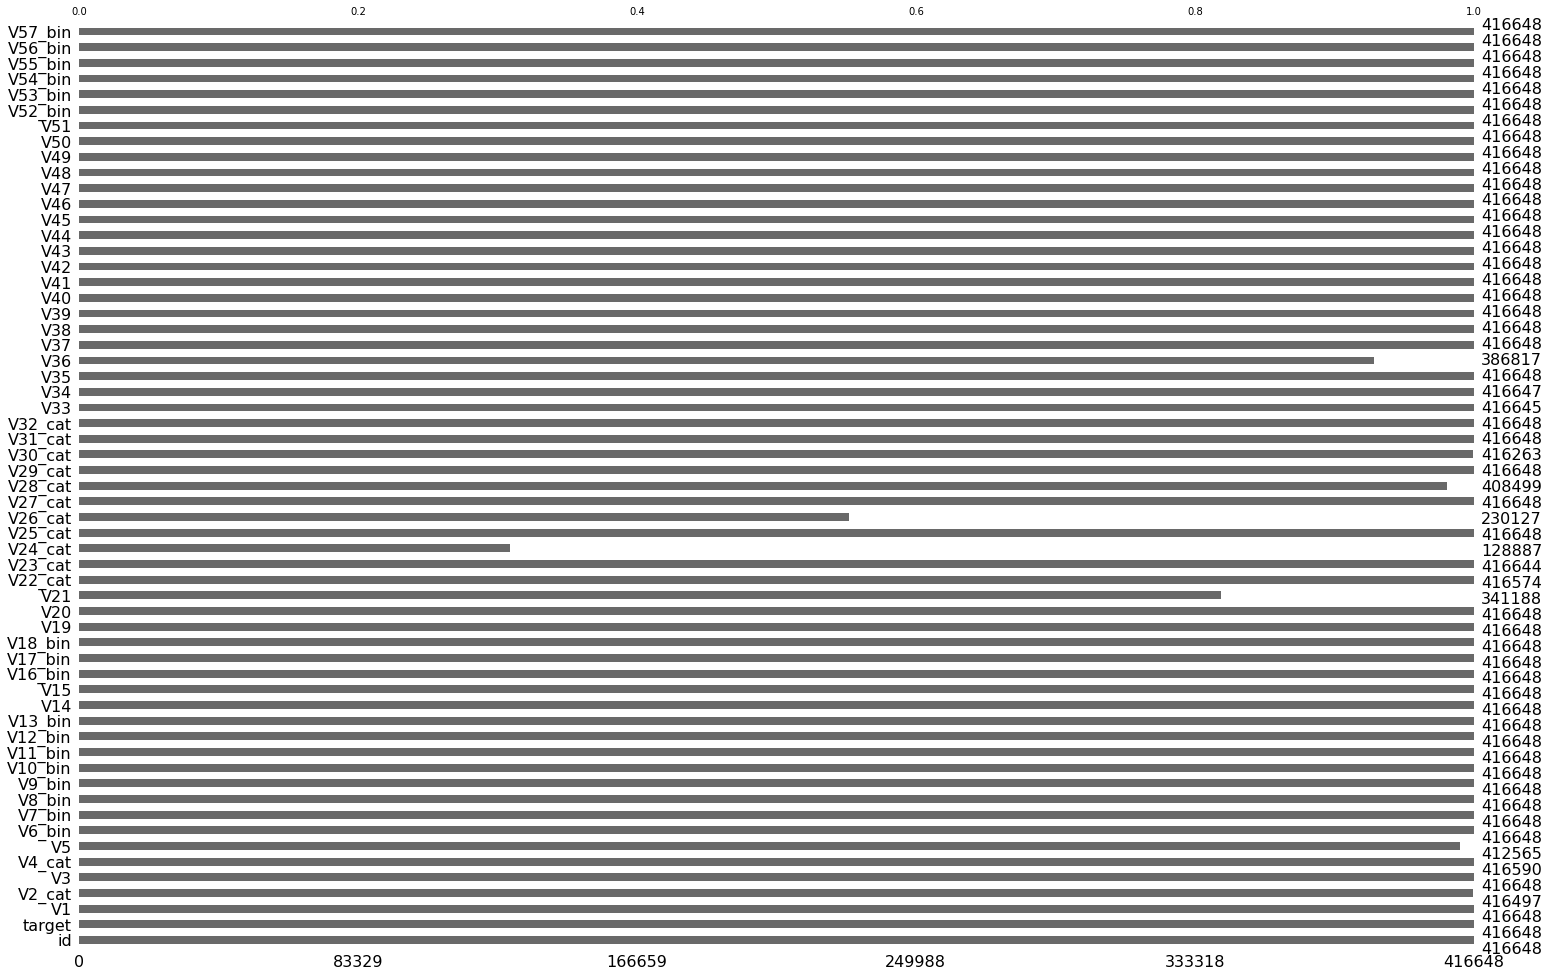

In [6]:
msno.bar(train) # 변수별 NA 비율

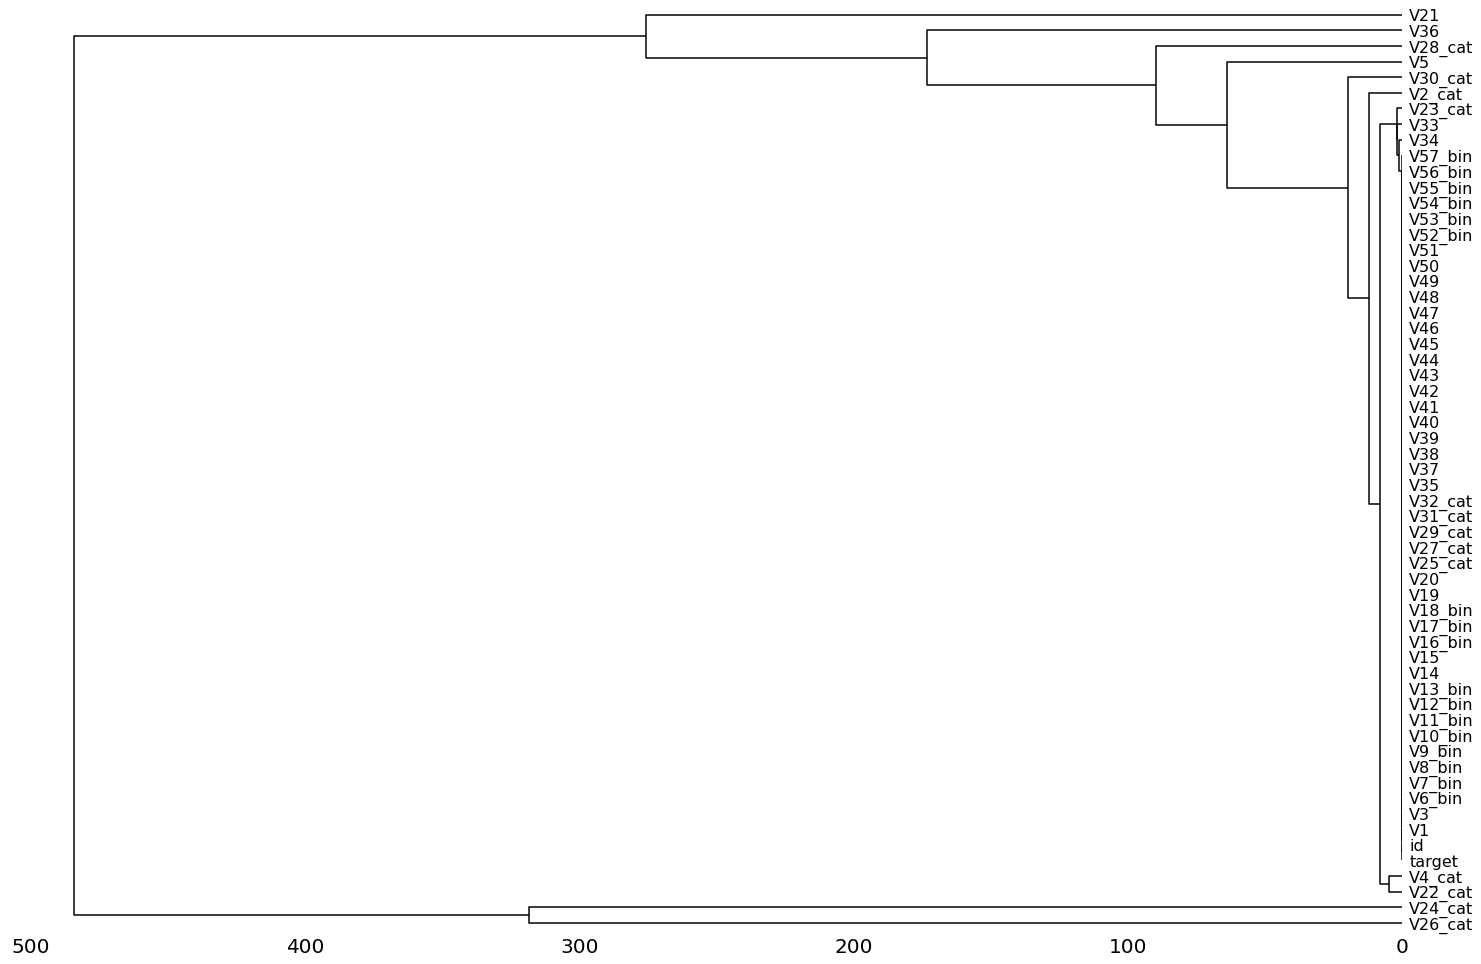

In [7]:
msno.dendrogram(train)

NA missing에 대한 dendrogram을 살펴보니, V24_cat과 V26_cat이 함께 NA가 발생하는 경향이 있으므로, 본 분석에서는 해당 두 변수를 제거하고 이후 NA imputation을 진행하였다.

In [8]:
train = train.drop(labels=["V24_cat", "V26_cat"],axis=1)
test = test.drop(labels=["V24_cat", "V26_cat"],axis=1) # V24_cat, V26_cat 제거

In [9]:
nan_colnames = [] # NA 존재 변수명 모음

for f in train.columns:
    n_missings = train[np.isnan(train[f])==False][f].count()
    if n_missings < len(train):
        nan_colnames.append(f)

In [10]:
nan_colnames # NA 존재 변수명

['V2_cat',
 'V4_cat',
 'V5',
 'V21',
 'V22_cat',
 'V23_cat',
 'V28_cat',
 'V30_cat',
 'V33',
 'V34',
 'V36']

In [11]:
# 각 변수별 분포를 고려한 복원추출을 통해 NA imputation
import random

for i in nan_colnames:
    train.loc[np.isnan(train[i]),i] = np.random.choice(train.loc[np.invert(np.isnan(train[i])), i].to_list(), size=sum(np.isnan(train[i])==True), replace = True)

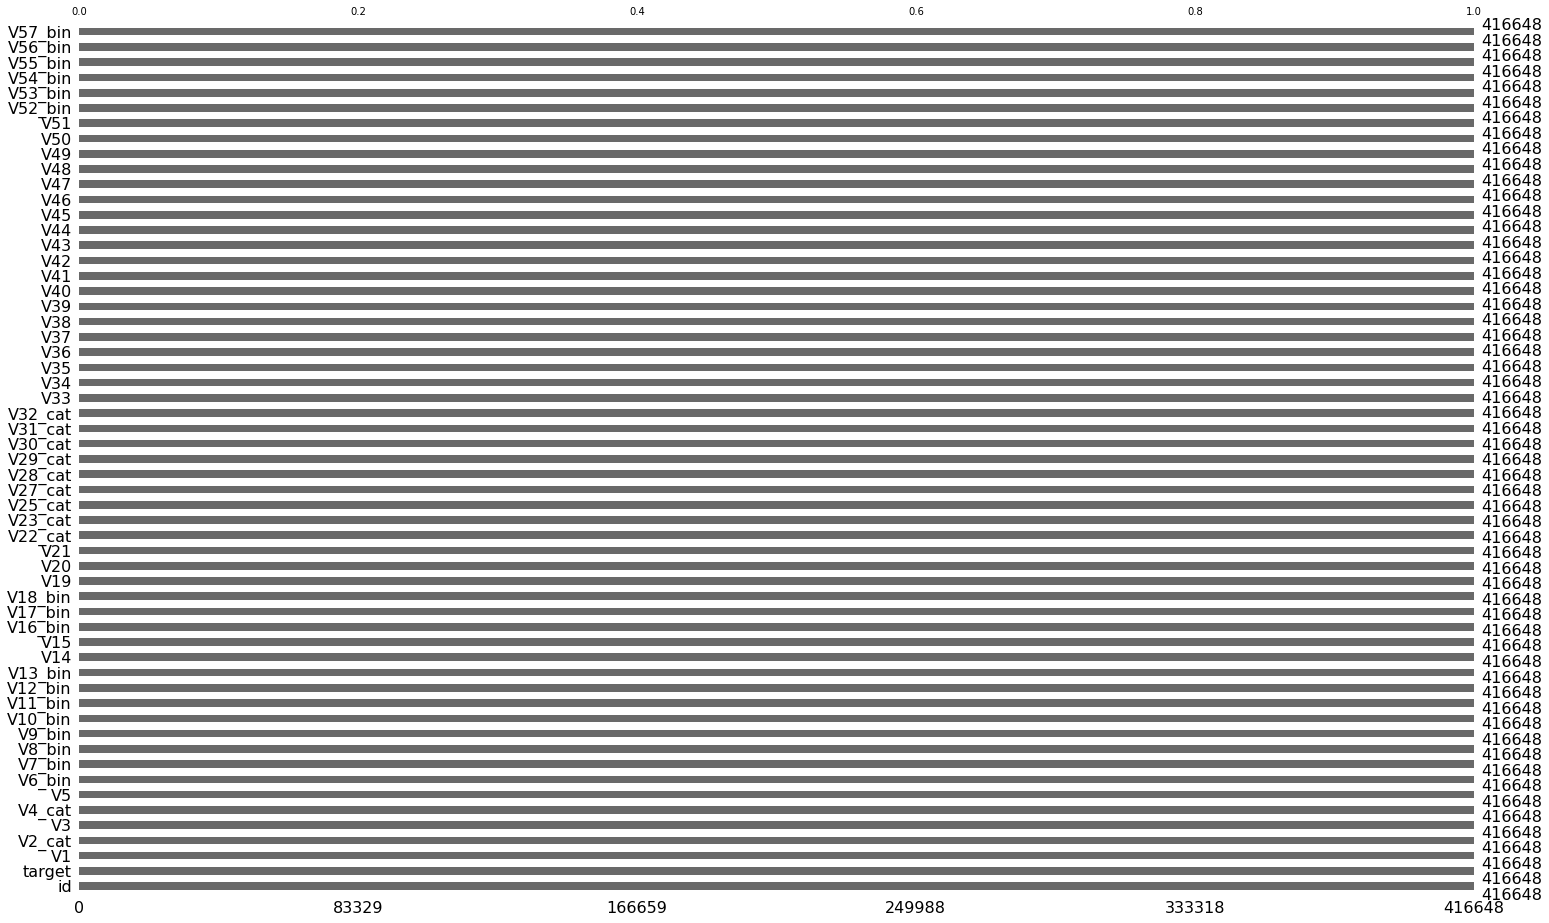

In [12]:
msno.bar(train) # 변수별 NA 비율

NA값이 잘 채워졌음을 확인하였다.

In [13]:
nan_colnames_test = [] # NA 존재 변수명 모음

for f in test.columns:
    n_missings = test[np.isnan(test[f])==False][f].count()
    if n_missings < len(test):
        nan_colnames_test.append(f)

In [14]:
# 각 변수별 분포를 고려한 복원추출을 통해 NA imputation
import random

for i in nan_colnames:
    test.loc[np.isnan(test[i]),i] = np.random.choice(train.loc[np.invert(np.isnan(train[i])), i].to_list(), size=sum(np.isnan(test[i])==True), replace = True)

# 2. EDA

## 변수선택

In [15]:
x_train = train.drop(labels=["id", "target"], axis = 1)
y_train = train["target"]

In [16]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#피처명 저장
feat_labels = x_train.columns

#랜덤포레스트 학습/중요도 저장
rf = RandomForestClassifier(n_estimators = 1000, random_state=804, n_jobs = -1)
rf.fit(x_train, y_train)
importances = rf. feature_importances_


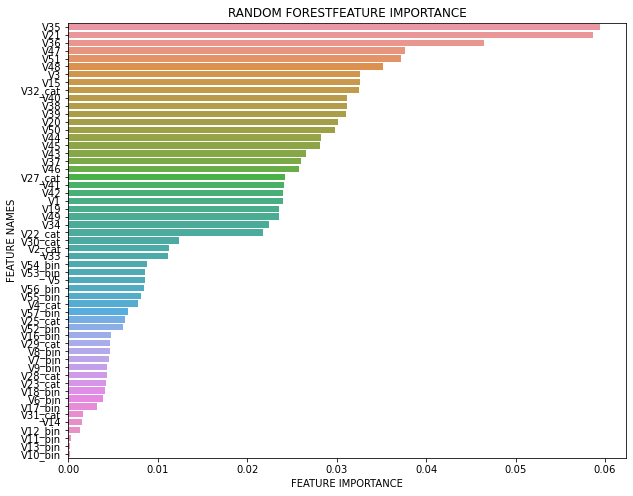

In [ ]:
import seaborn as sns

#시각화
def plot_feature_importance(importance,names,model_type):

    #피처 중요도/명 array 생성
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #데이터프레임 생성
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #정렬
    fi_df = fi_df.sort_values(by='feature_importance', ascending=False)
  

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(importances,feat_labels,'RANDOM FOREST')

### Relief Algorithm

본 알고리즘은 파이썬 코드로는 존재하나, running이 되지 않는 관계로, R코드로 진행한 결과를 아래 첨부하며, 또한 그에 따른 시각화와 변수 목록 또한 첨부하였다.

In [ ]:
# Relief algorithm in R
# library(CORElearn)
# RE = attrEval(target ~ ., data=train, estimator='Relief',
#               ReliefIterations=30)

# SRE = sort(RE, decreasing = T)
# SRE # 높은 순으로 그룹을 가르는데 있어 중요한 변수다

# plot(1:length(SRE),SRE, type='b', ylab='Separability',
#      xlab ='variables', main='Variable Importance', xaxt='n')
# axis(side=1, at=1:length(SRE), labels=names(SRE), cex.axis=0.8,las=2)

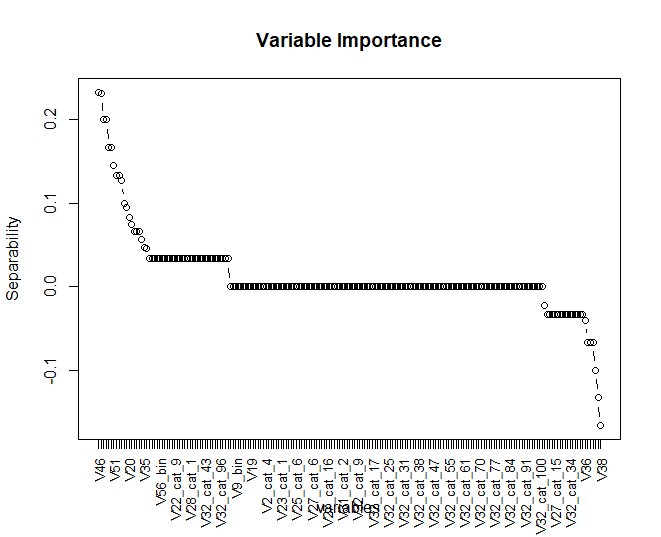

In [17]:
important_var = ['V46', 'V37', 'V44', 'V55_bin', 'V42', 'V43', 'V51' ,'V1', 'V53_bin', 'V21', 'V22_cat_4', 'V48', 'V20', 'V15', 'V52_bin', 'V26_cat_1', 'V27_cat_14',
                 'V3', 'V35', 'V34', 'V6_bin', 'V7_bin', 'V39', 'V54_bin', 'V56_bin', 'V2_cat_2', 'V22_cat_3', 'V22_cat_5', 'V22_cat_6', 'V22_cat_8', 'V22_cat_9',
                 'V25_cat_8', 'V27_cat_3', 'V27_cat_4', 'V27_cat_11', 'V27_cat_13', 'V28_cat_1', 'V29_cat_1', 'V32_cat_10' ,'V32_cat_19', 'V32_cat_40',
                 'V32_cat_42', 'V32_cat_43', 'V32_cat_51', 'V32_cat_64', 'V32_cat_76', 'V32_cat_79', 'V32_cat_88', 'V32_cat_96', 'V32_cat_98',
                 'V32_cat_101', 'V32_cat_103'] # Relief Algorithm 상 상위 중요 변수 (중요도 내림차순 기재)

In [18]:
least_important_var = ['V47', 'V17_bin', 'V18_bin', 'V26_cat_범주 미상', 'V27_cat_15', 'V30_cat_1', 'V32_cat_2', 'V32_cat_8', 'V32_cat_16',
                       'V32_cat_20', 'V32_cat_34', 'V32_cat_54', 'V32_cat_63', 'V32_cat_67', 'V32_cat_92', 'V32_cat_104', 'V36', 'V16_bin',
                       'V57_bin', 'V22_cat_7', 'V45', 'V49', 'V38' ] # Relief Algorithm 상으로 하위 중요 변수 (중요도 내림차순 기준 마지막에 위치한 변수)

# 범주형 변환

In [19]:
# 변수 형태별 리스트
cat_list = [a for a in train.columns if a.endswith('cat')]
int_list = [a for a in train.columns if a not in cat_list]
bin_list = [a for a in train.columns if a.endswith('bin')]
int_list2 = [a for a in train.columns if a not in cat_list and a not in bin_list]
int_list_rm = int_list2[2:] #id랑 target 제거한 리스트

In [20]:
# 범주형 변환 
train[cat_list] = train[cat_list].astype('category')
test[cat_list] = test[cat_list].astype('category')

# 상관계수 plot

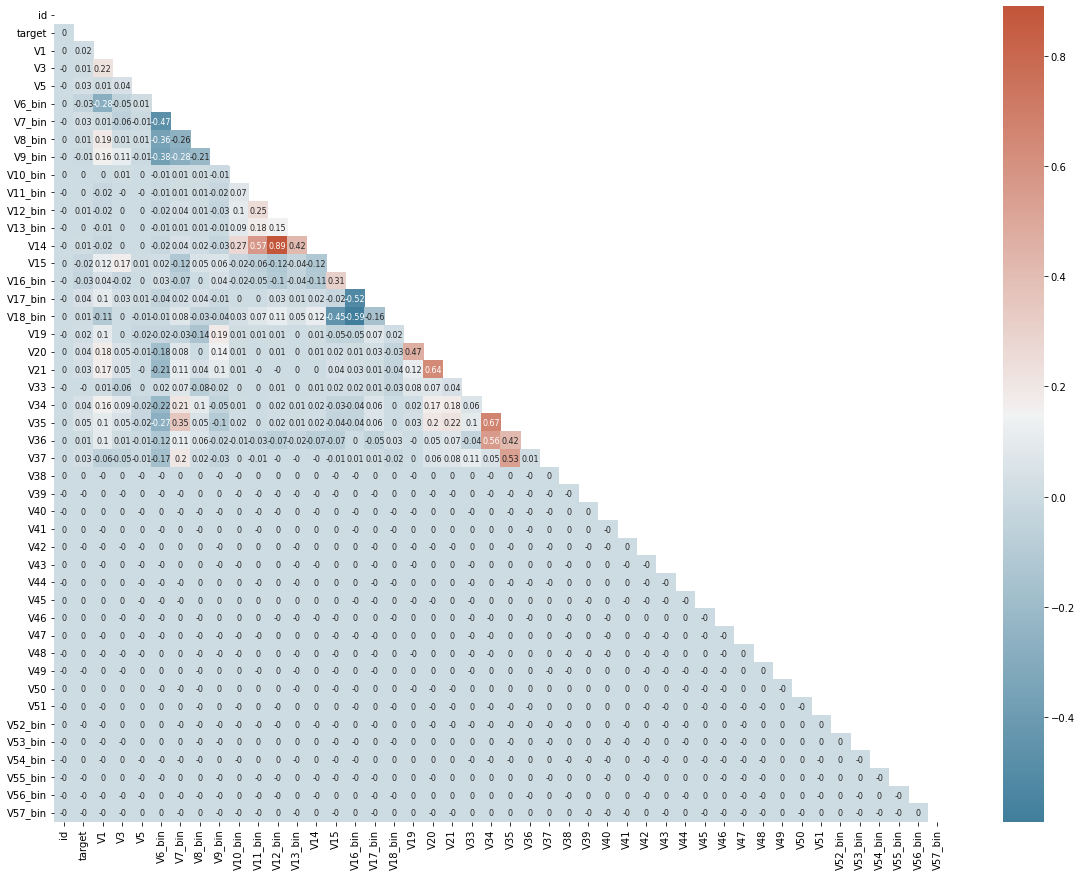

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 변수 
train_int = train[int_list]
corr = train_int.corr().round(2)
f, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, annot_kws={"size": 8}) 

# 0.89로 상관계수가 높은 변수들이 있어 제거한 후 모델링 해봤는데 좋은 결과를 얻지 못함.

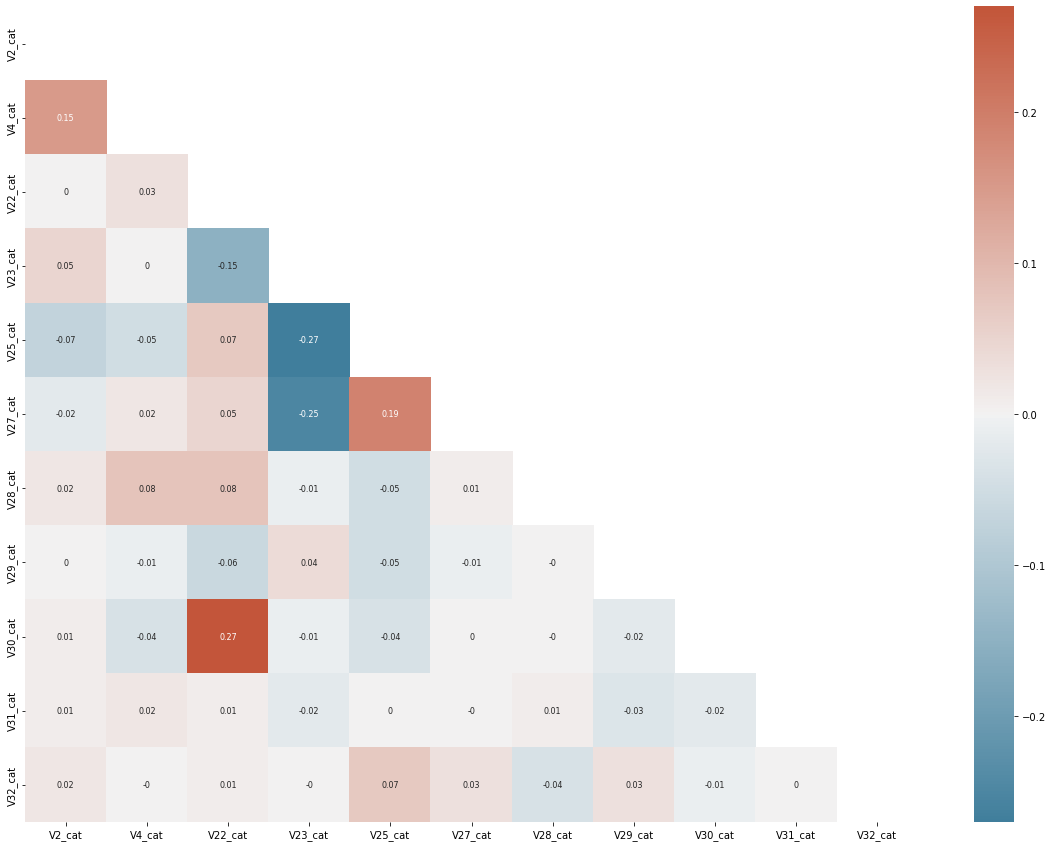

In [23]:
# 범주형 변수 
train_cat = train[cat_list].astype('int')
corr = train_cat.corr().round(2)
f, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, annot_kws={"size": 8}) 

# 변수별 분포 시각화

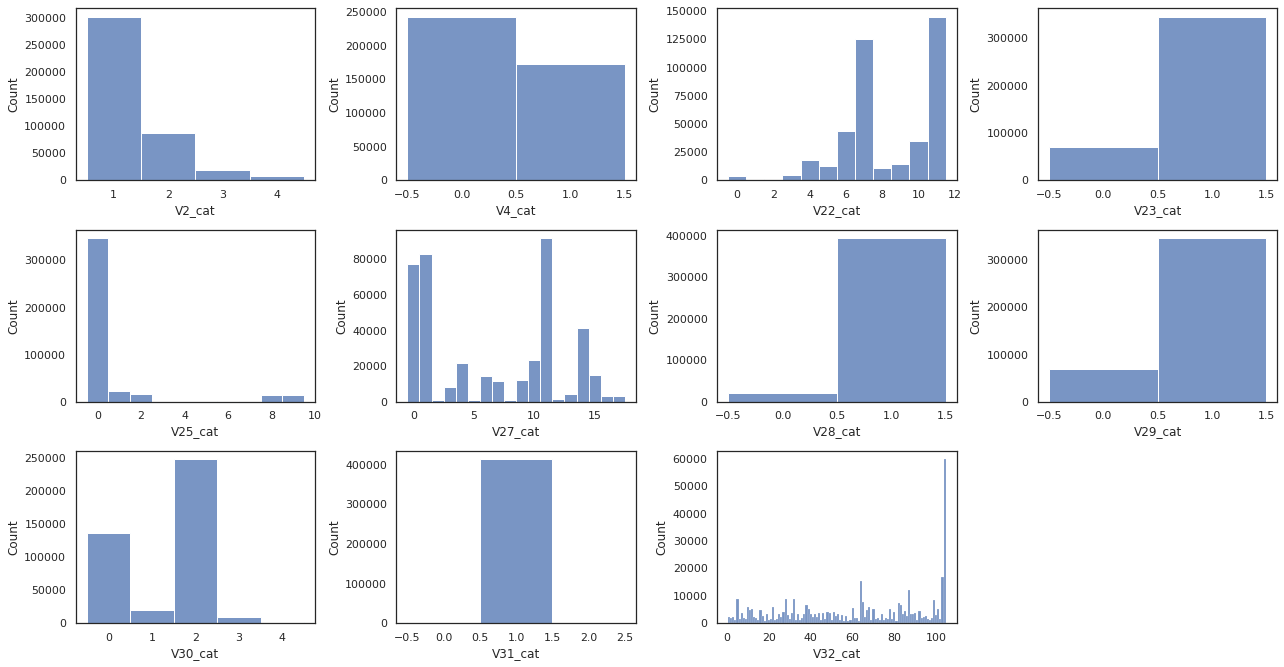

In [24]:
# category 변수
plt.subplots(figsize=(18, 12))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(cat_list, 1):
    plt.subplot(4,4,i)
    sns.histplot(train[column])
    
plt.tight_layout()

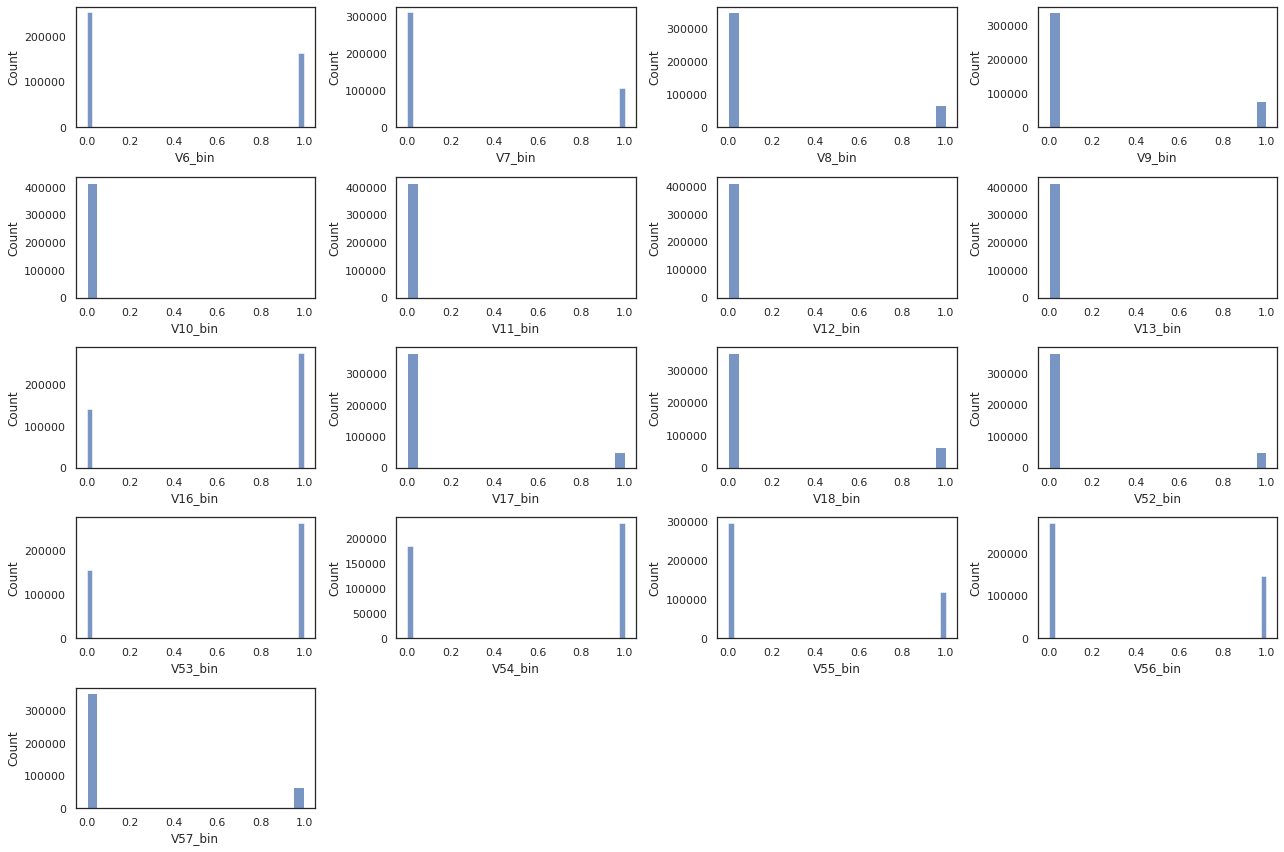

In [25]:
# bin 변수
plt.subplots(figsize=(18, 12))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(bin_list, 1):
    plt.subplot(5,4,i)
    sns.histplot(train[column])
    
plt.tight_layout()

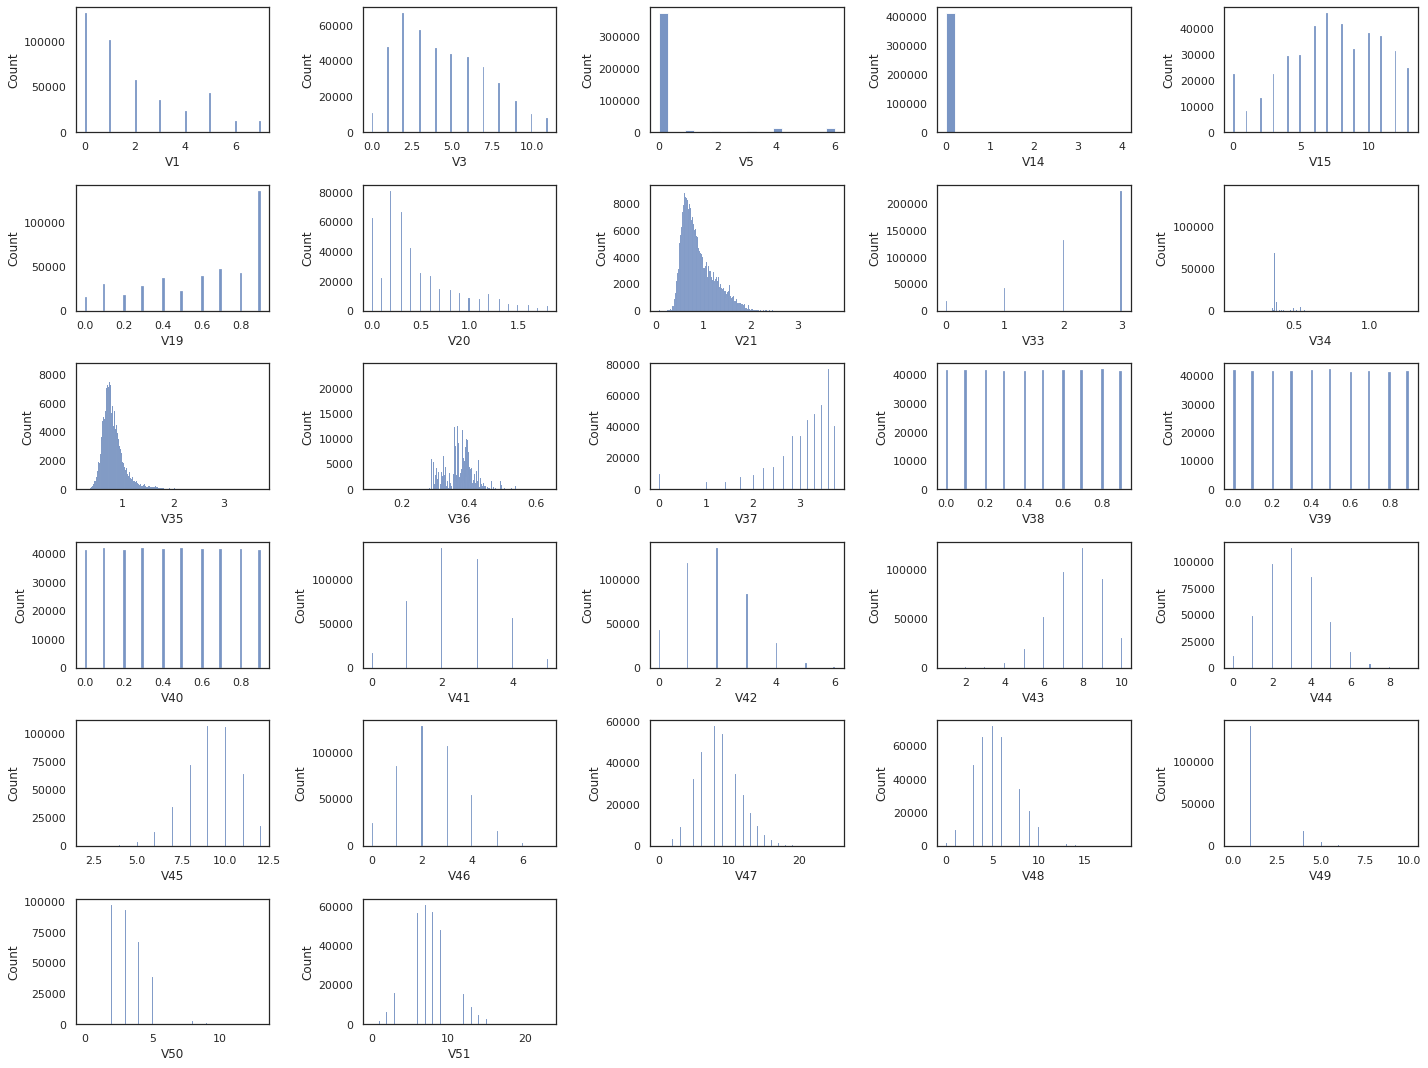

In [26]:
# 수치형 변수
plt.subplots(figsize=(20, 15))
sns.set(font_scale = 1, style = 'white')

for i, column in enumerate(int_list_rm, 1):
    plt.subplot(6,5,i)
    sns.histplot(train[column])
    
plt.tight_layout()

# target 분포 시각화

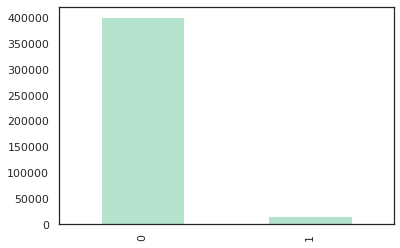

In [27]:
train['target'].value_counts().plot(kind="bar", colormap='Pastel2') #클래스 불균형으로 과적합 가능: under나 over sampling 필요

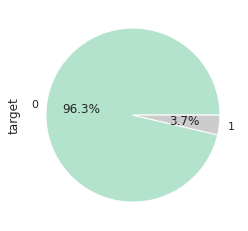

In [28]:
train['target'].value_counts().plot(kind="pie", colormap='Pastel2', autopct='%1.1f%%')